In [4]:
from pyspark import SparkConf, SparkContext
import pandas as pd

**SparkConf**
사용자가 재정의해서 쓸 수 있는 설정 옵션들에 대한 키와 값을 갖고있는 객체


**SparkContext**
Spark 클러스터와 연결시켜주는 객체


* Spark 모든 기능에 접근할 수 있는 시작점
* Spark는 분산환경에서 동작하기 때문에 Driver Program 을 구동시키기 위해 SparkContext가 필요
* SparkContext는 프로그램당 하나만 만들 수 있고 사용후에는 종료


## SparkContext 초기화

![sparkcontext](assets/sparkcontext.png)

* SparkContext 객체는 내부에 자바로 동작하는 Py4J의 SparkContext와 연결
* 이 덕분에 파이썬으로 코딩하면서도 자바 위에서 동작하는 프로그램을 작성할 수 있다 
* RDD를 만들 수 있다

In [5]:
# Spark 설정
conf = SparkConf().setMaster("local").setAppName("uber-date-trips")
sc = SparkContext(conf=conf)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/13 21:43:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


setMaster("local") - 분산된 환경이 아닌 개발용 로컬 환경을 쓴다

setAppName - Spark UI에서 확인 가능한 스파크 앱 이름

In [9]:
# 우리가 가져올 데이터가 있는 파일
directory = "/Users/sion/Workspace/data-engineering/01-spark/data"
filename = "fhvhv_tripdata_2020-03.csv"

## 데이터 로딩후 RDD 생성

In [10]:
lines = sc.textFile(f"file:///{directory}/{filename}")

*데이터*
```
hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,
HV0005,B02510,2020-03-01 00:28:05,2020-03-01 00:38:57,168,119,
HV0003,B02764,2020-03-01 00:03:07,2020-03-01 00:15:04,137,209,1
HV0003,B02764,2020-03-01 00:18:42,2020-03-01 00:38:42,209,80,
HV0003,B02764,2020-03-01 00:44:24,2020-03-01 00:58:44,256,226,
...
```

## 필요한 부분만 추출하기

In [11]:
header = lines.first() 
filtered_lines = lines.filter(lambda row:row != header) 

아래와 같습니다
```python
def f(row):
    return row != header
lines.filter(f) 
```

*데이터*
```
HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,
HV0005,B02510,2020-03-01 00:28:05,2020-03-01 00:38:57,168,119,
HV0003,B02764,2020-03-01 00:03:07,2020-03-01 00:15:04,137,209,1
HV0003,B02764,2020-03-01 00:18:42,2020-03-01 00:38:42,209,80,
HV0003,B02764,2020-03-01 00:44:24,2020-03-01 00:58:44,256,226,
...
```

In [12]:
dates = filtered_lines.map(lambda x: x.split(",")[2].split(" ")[0])

**map()**함수로 우리가 원하는 부분만 추출 할 수 있다


추출하는 함수
```python
lambda x: x.split(",")[2].split(" ")[0]

```
아래와 같다

```python]
def f(x):
    return x.split(",")[2].split(" ")[0]
```


오리지널 데이터
```
HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,
```

x.split(",")
```
[HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,]
```


x.split(",")[2]
```
[2020-03-01 00:03:40]
```


x.split(",")[2].split(" ")
```
[2020-03-01,00:03:40]
```

x.split(",")[2].split(" ")[0]
```
2020-03-01
```

## CountByValue

In [13]:
result = dates.countByValue()

값이 얼마나 등장하는지 세준다 

예)
```
2020-03-01
2020-03-01
2020-03-01
2020-03-02
2020-03-02
2020-03-03
```
countByValue()
```
(2020-03-01,3)
(2020-03-02,2)
(2020-03-03,1)
```


**result는 이제 더이상 RDD가 아닌 Python 객체**

In [14]:
# 아래는 Spark코드가 아닌 일반적인 파이썬 코드
# CSV로 결과값 저장 
pd.Series(result, name="trips").to_csv("trips_date.csv")

<AxesSubplot:>

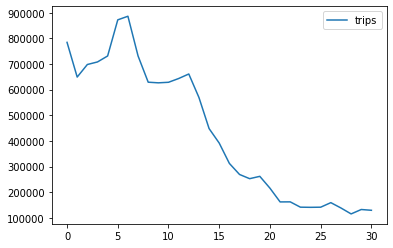

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline  

trips = pd.read_csv("trips_date.csv")
trips.plot()